<a href="https://colab.research.google.com/github/filipchudzynski/stock-market-non-gaussianity-analyzer_v2/blob/main/basic_analysis_of_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S&P 500

## get the data from www.histdata.com

In [1]:
! pip install selenium pandas openpyxl webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0


In [2]:
!apt-get update
!apt-get install -y wget unzip
!wget -q https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt-get install -y ./google-chrome-stable_current_amd64.deb


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,892 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,712 kB]
Get:14 http://

In [3]:
# run in terminal !CHROME_VERSION=$(google-chrome --version | grep -oP '\d+\.\d+\.\d+')


!wget -q "https://storage.googleapis.com/chrome-for-testing-public/144.0.7559.132/linux64/chromedriver-linux64.zip" -O chromedriver.zip
!unzip chromedriver.zip
!mv chromedriver-linux64/chromedriver /usr/local/bin/
!chmod +x /usr/local/bin/chromedriver


Archive:  chromedriver.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  


In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from pathlib import Path

def get_driver(download_dir="/content/downloads"):
    Path(download_dir).mkdir(exist_ok=True)

    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    prefs = {
        "download.default_directory": download_dir,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True,
    }
    options.add_experimental_option("prefs", prefs)

    return webdriver.Chrome(options=options)



In [26]:
import time
import zipfile
from pathlib import Path
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np

DOWNLOAD_DIR = "/content/downloads"
BASE_URL = "https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/{year}"

driver = get_driver(DOWNLOAD_DIR)  # reuse the headless driver you already defined

def download_year(year):
    print(f"Processing {year}...")
    driver.get(BASE_URL.format(year=year))


    time.sleep(2)

    # Debug: show what page we actually loaded
    print("Current URL:", driver.current_url)
    print("Page title:", driver.title)


    # 1. Close cookie banner if present
    try:
        accept_btn = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.ID, "cookie_action_close_header"))
        )
        accept_btn.click()
        time.sleep(1)
        print("Cookie banner dismissed")
    except:
        print("No cookie banner found")

    # Extract the visible year from the page
    try:
        year_text = driver.find_element(By.XPATH, "//p[b[contains(text(),'Year/Month')]]").text
        print("Page shows:", year_text)
    except:
        print("Could not read Year/Month from page")

    # Extract the download filename text
    try:
        file_label = driver.find_element(By.ID, "a_file").text
        print("Download link text:", file_label)
    except:
        print("Could not read download link text")

    # Now proceed with clicking
    try:
        link = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, "a_file"))
        )
    except Exception as e:
        print(f"Could not find download link for {year}: {e}")
        return None

    # 3. Click the download link
    link.click()
    print("Clicked download link")

    # 4. Wait for ZIP to appear
    zip_path = Path(DOWNLOAD_DIR) / f"{year}.zip"
    for _ in range(40):
        for f in Path(DOWNLOAD_DIR).glob(f"*{year}.zip"):
            print(f"{f} found")
            f.rename(zip_path)
            print("Downloaded ZIP →", zip_path)
            return zip_path
        time.sleep(1)

    print("Failed to download", year)
    return None


def extract_and_convert(zip_path):
    year = zip_path.stem
    with zipfile.ZipFile(zip_path, "r") as z:
        xlsx_name = next(n for n in z.namelist() if n.lower().endswith(".xlsx"))
        xlsx_path = Path(DOWNLOAD_DIR) / f"{year}.xlsx"
        z.extract(xlsx_name, DOWNLOAD_DIR)
        (Path(DOWNLOAD_DIR) / xlsx_name).rename(xlsx_path)
        print("Extracted XLSX →", xlsx_path)

    df = pd.read_excel(xlsx_path)
    display(df.head())
    csv_path = Path(DOWNLOAD_DIR) / f"{year}.csv"
    df.to_csv(csv_path, index=False)
    print("Converted to CSV →", csv_path)

# run it
for year in range(2010, 2025):
    zip_file = download_year(year)
    if zip_file:
        extract_and_convert(zip_file)

driver.quit()


Processing 2010...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2010
Page title: Download Free Forex Historical Data – HistData.com
Cookie banner dismissed
Page shows: Year/Month: 2010
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2010.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12010.zip found
Downloaded ZIP → /content/downloads/2010.zip
Extracted XLSX → /content/downloads/2010.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2010-11-14 18:00:00,1195.5,1195.75,1195.5.1,1195.75.1,0
0,2010-11-14 18:01:00,1195.50,1195.75,1195.50,1195.50,0
1,2010-11-14 18:02:00,1195.25,1195.50,1195.00,1195.25,0
2,2010-11-14 18:03:00,1195.50,1195.50,1195.50,1195.50,0
3,2010-11-14 18:04:00,1195.75,1195.75,1195.50,1195.75,0
4,2010-11-14 18:05:00,1196.00,1196.25,1195.75,1196.00,0


Converted to CSV → /content/downloads/2010.csv
Processing 2011...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2011
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2011
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2011.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12011.zip found
Downloaded ZIP → /content/downloads/2011.zip
Extracted XLSX → /content/downloads/2011.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2011-01-02 18:08:00,1256.25,1256.25.1,1256.25.2,1256.25.3,0
0,2011-01-02 18:12:00,1256.00,1256.00,1256.00,1256.00,0
1,2011-01-02 18:13:00,1256.00,1256.25,1256.00,1256.00,0
2,2011-01-02 18:14:00,1256.25,1256.25,1256.25,1256.25,0
3,2011-01-02 18:15:00,1256.50,1256.50,1256.25,1256.25,0
4,2011-01-02 18:18:00,1256.50,1256.50,1256.50,1256.50,0


Converted to CSV → /content/downloads/2011.csv
Processing 2012...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2012
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2012
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2012.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12012.zip found
Downloaded ZIP → /content/downloads/2012.zip
Extracted XLSX → /content/downloads/2012.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2012-01-03 06:00:00,1275.88,1278.88,1275.63,1276.63,0
0,2012-01-03 06:01:00,1276.88,1277.38,1276.63,1276.63,0
1,2012-01-03 06:02:00,1276.38,1276.38,1275.38,1275.38,0
2,2012-01-03 06:03:00,1275.25,1276.13,1275.25,1276.13,0
3,2012-01-03 06:04:00,1275.88,1275.88,1275.13,1275.13,0
4,2012-01-03 06:05:00,1274.88,1274.88,1273.88,1273.88,0


Converted to CSV → /content/downloads/2012.csv
Processing 2013...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2013
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2013
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2013.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12013.zip found
Downloaded ZIP → /content/downloads/2013.zip
Extracted XLSX → /content/downloads/2013.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2013-01-02 06:00:00,1423,1442.75,1423.1,1440,0
0,2013-01-02 06:01:00,1440.25,1441.50,1440.25,1441.00,0
1,2013-01-02 06:02:00,1440.75,1443.00,1440.75,1443.00,0
2,2013-01-02 06:03:00,1443.25,1444.75,1443.00,1444.25,0
3,2013-01-02 06:04:00,1444.00,1444.00,1443.50,1444.00,0
4,2013-01-02 06:05:00,1444.00,1444.75,1444.00,1444.00,0


Converted to CSV → /content/downloads/2013.csv
Processing 2014...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2014
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2014
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2014.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12014.zip found
Downloaded ZIP → /content/downloads/2014.zip
Extracted XLSX → /content/downloads/2014.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2014-01-01 18:05:00,1846,1846.1,1846.2,1846.3,0
0,2014-01-02 06:00:00,1836.75,1836.75,1834.25,1834.25,0
1,2014-01-02 06:01:00,1834.50,1835.00,1834.50,1834.50,0
2,2014-01-02 06:02:00,1834.25,1835.25,1834.25,1835.25,0
3,2014-01-02 06:03:00,1835.50,1836.75,1835.50,1836.25,0
4,2014-01-02 06:04:00,1836.50,1836.75,1836.25,1836.75,0


Converted to CSV → /content/downloads/2014.csv
Processing 2015...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2015
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2015
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2015.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12015.zip found
Downloaded ZIP → /content/downloads/2015.zip
Extracted XLSX → /content/downloads/2015.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2015-01-01 18:00:00,2055,2057.5,2055.1,2057.25,0
0,2015-01-01 18:01:00,2057.00,2057.25,2056.50,2057.25,0
1,2015-01-01 18:02:00,2057.00,2057.25,2056.50,2057.00,0
2,2015-01-01 18:03:00,2056.75,2057.00,2056.50,2057.00,0
3,2015-01-01 18:04:00,2056.75,2056.75,2056.75,2056.75,0
4,2015-01-01 18:06:00,2057.00,2057.00,2056.75,2057.00,0


Converted to CSV → /content/downloads/2015.csv
Processing 2016...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2016
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2016
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2016.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12016.zip found
Downloaded ZIP → /content/downloads/2016.zip
Extracted XLSX → /content/downloads/2016.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2016-01-03 18:01:00,2037.75,2040.75,2037.75.1,2040.75.1,0
0,2016-01-03 18:02:00,2040.75,2041.75,2040.75,2041.50,0
1,2016-01-03 18:03:00,2041.75,2042.00,2041.75,2042.00,0
2,2016-01-03 18:04:00,2042.25,2042.25,2041.75,2041.75,0
3,2016-01-03 18:05:00,2042.00,2042.00,2041.75,2042.00,0
4,2016-01-03 18:06:00,2042.25,2042.50,2042.25,2042.50,0


Converted to CSV → /content/downloads/2016.csv
Processing 2017...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2017
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2017
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2017.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12017.zip found
Downloaded ZIP → /content/downloads/2017.zip
Extracted XLSX → /content/downloads/2017.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2017-01-02 18:00:00,2241,2244.5,2241.1,2243.5,0
0,2017-01-02 18:01:00,2243.75,2243.75,2243.00,2243.00,0
1,2017-01-02 18:02:00,2243.25,2243.25,2243.00,2243.25,0
2,2017-01-02 18:03:00,2243.00,2243.00,2243.00,2243.00,0
3,2017-01-02 18:04:00,2243.25,2243.75,2243.25,2243.75,0
4,2017-01-02 18:05:00,2243.75,2244.00,2243.75,2243.75,0


Converted to CSV → /content/downloads/2017.csv
Processing 2018...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2018
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2018
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2018.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12018.zip found
Downloaded ZIP → /content/downloads/2018.zip
Extracted XLSX → /content/downloads/2018.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2018-01-01 16:30:00,2668,2668.1,2668.2,2668.3,0
0,2018-01-01 18:00:00,2675.00,2676.75,2674.50,2676.50,0
1,2018-01-01 18:01:00,2676.75,2677.75,2676.75,2677.75,0
2,2018-01-01 18:02:00,2677.50,2678.50,2677.50,2678.50,0
3,2018-01-01 18:03:00,2678.25,2678.25,2678.00,2678.25,0
4,2018-01-01 18:04:00,2678.13,2678.25,2678.00,2678.25,0


Converted to CSV → /content/downloads/2018.csv
Processing 2019...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2019
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2019
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2019.zip
Clicked download link
/content/downloads/HISTDATA_COM_XLSX_SPXUSD_M12019.zip found
Downloaded ZIP → /content/downloads/2019.zip
Extracted XLSX → /content/downloads/2019.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2019-01-01 18:00:00,2506.769,2508.07,2505.57,2508.07.1,0
0,2019-01-01 18:01:00,2508.070,2511.57,2507.770,2511.269,0
1,2019-01-01 18:02:00,2511.269,2516.27,2510.770,2515.270,0
2,2019-01-01 18:03:00,2515.270,2515.77,2514.270,2514.270,0
3,2019-01-01 18:04:00,2514.270,2515.07,2514.269,2514.270,0
4,2019-01-01 18:05:00,2514.270,2514.27,2513.769,2514.070,0


Converted to CSV → /content/downloads/2019.csv
Processing 2020...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2020
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2020
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2020.zip
Clicked download link
/content/downloads/2020.zip found
Downloaded ZIP → /content/downloads/2020.zip
Extracted XLSX → /content/downloads/2020.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2020-01-01 18:00:00,3234.552,3235.537,3234.534,3234.837,0
0,2020-01-01 18:01:00,3234.837,3234.837,3233.337,3233.337,0
1,2020-01-01 18:02:00,3233.337,3233.852,3233.334,3233.740,0
2,2020-01-01 18:03:00,3233.740,3234.600,3233.552,3234.346,0
3,2020-01-01 18:04:00,3234.346,3234.352,3233.852,3233.855,0
4,2020-01-01 18:05:00,3233.855,3234.100,3233.837,3233.900,0


Converted to CSV → /content/downloads/2020.csv
Processing 2021...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2021
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2021
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2021.zip
Clicked download link
/content/downloads/2021.zip found
Downloaded ZIP → /content/downloads/2021.zip
Extracted XLSX → /content/downloads/2021.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2021-01-03 18:00:00,3758.942,3762.397,3756.854,3757.954,0
0,2021-01-03 18:01:00,3758.137,3759.436,3756.231,3756.254,0
1,2021-01-03 18:02:00,3756.231,3756.231,3749.936,3752.242,0
2,2021-01-03 18:03:00,3752.446,3754.754,3751.139,3752.636,0
3,2021-01-03 18:04:00,3752.631,3754.297,3752.434,3753.433,0
4,2021-01-03 18:05:00,3753.449,3754.242,3752.942,3753.436,0


Converted to CSV → /content/downloads/2021.csv
Processing 2022...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2022
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2022
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2022.zip
Clicked download link
/content/downloads/2022.zip found
Downloaded ZIP → /content/downloads/2022.zip
Extracted XLSX → /content/downloads/2022.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2022-01-02 18:00:00,4779.636,4785.539,4779.636.1,4781.251,0
0,2022-01-02 18:01:00,4781.136,4784.099,4780.133,4782.736,0
1,2022-01-02 18:02:00,4782.836,4784.242,4781.342,4781.348,0
2,2022-01-02 18:03:00,4781.648,4782.151,4780.142,4780.242,0
3,2022-01-02 18:04:00,4780.145,4781.699,4779.836,4781.633,0
4,2022-01-02 18:05:00,4781.233,4782.699,4781.133,4781.854,0


Converted to CSV → /content/downloads/2022.csv
Processing 2023...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2023
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2023
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2023.zip
Clicked download link
/content/downloads/2023.zip found
Downloaded ZIP → /content/downloads/2023.zip
Extracted XLSX → /content/downloads/2023.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,2023-01-02 18:00:00,3872.998,3877.176,3863.86,3865.983,0
0,2023-01-02 18:01:00,3866.128,3867.372,3865.378,3865.980,0
1,2023-01-02 18:02:00,3865.878,3866.878,3865.360,3865.881,0
2,2023-01-02 18:03:00,3865.742,3865.742,3862.860,3863.613,0
3,2023-01-02 18:04:00,3863.363,3863.363,3860.742,3860.878,0
4,2023-01-02 18:05:00,3861.113,3864.378,3860.875,3864.119,0


Converted to CSV → /content/downloads/2023.csv
Processing 2024...
Current URL: https://www.histdata.com/download-free-forex-historical-data/?/excel/1-minute-bar-quotes/spxusd/2024
Page title: Download Free Forex Historical Data – HistData.com
No cookie banner found
Page shows: Year/Month: 2024
 
Download link text: HISTDATA_COM_XLSX_SPXUSD_M1_2024.zip
Clicked download link
Failed to download 2024


## data quality

In [27]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content/downloads")

csv_files = sorted(DATA_DIR.glob("*.csv"))
dfs_sandp = []
print(csv_files)
for f in csv_files:
    df = pd.read_csv(f, header=None)
    df.columns = [ "timestamp", "open", "high", "low", "close","vol" ]
    dfs_sandp.append(df)

# data = pd.concat(dfs, ignore_index=True)
# print("Loaded rows:", len(data))
for df in dfs_sandp:
  display(df.head())


[PosixPath('/content/downloads/2010.csv'), PosixPath('/content/downloads/2011.csv'), PosixPath('/content/downloads/2012.csv'), PosixPath('/content/downloads/2013.csv'), PosixPath('/content/downloads/2014.csv'), PosixPath('/content/downloads/2015.csv'), PosixPath('/content/downloads/2016.csv'), PosixPath('/content/downloads/2017.csv'), PosixPath('/content/downloads/2018.csv'), PosixPath('/content/downloads/2019.csv'), PosixPath('/content/downloads/2020.csv'), PosixPath('/content/downloads/2021.csv'), PosixPath('/content/downloads/2022.csv'), PosixPath('/content/downloads/2023.csv')]


/tmp/ipython-input-4013738031.py:10: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
/tmp/ipython-input-4013738031.py:10: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
/tmp/ipython-input-4013738031.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
/tmp/ipython-input-4013738031.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)


,timestamp,open,high,low,close,vol
0,2010-11-14 18:00:00,1195.50,1195.75,1195.5.1,1195.75.1,0
1,2010-11-14 18:01:00,1195.50,1195.75,1195.5,1195.5,0
2,2010-11-14 18:02:00,1195.25,1195.50,1195.0,1195.25,0
3,2010-11-14 18:03:00,1195.50,1195.50,1195.5,1195.5,0
4,2010-11-14 18:04:00,1195.75,1195.75,1195.5,1195.75,0


,timestamp,open,high,low,close,vol
0,2011-01-02 18:08:00,1256.25,1256.25.1,1256.25.2,1256.25.3,0
1,2011-01-02 18:12:00,1256.00,1256.0,1256.0,1256.0,0
2,2011-01-02 18:13:00,1256.00,1256.25,1256.0,1256.0,0
3,2011-01-02 18:14:00,1256.25,1256.25,1256.25,1256.25,0
4,2011-01-02 18:15:00,1256.50,1256.5,1256.25,1256.25,0


,timestamp,open,high,low,close,vol
0,2012-01-03 06:00:00,1275.88,1278.88,1275.63,1276.63,0
1,2012-01-03 06:01:00,1276.88,1277.38,1276.63,1276.63,0
2,2012-01-03 06:02:00,1276.38,1276.38,1275.38,1275.38,0
3,2012-01-03 06:03:00,1275.25,1276.13,1275.25,1276.13,0
4,2012-01-03 06:04:00,1275.88,1275.88,1275.13,1275.13,0


,timestamp,open,high,low,close,vol
0,2013-01-02 06:00:00,1423.00,1442.75,1423.10,1440.00,0
1,2013-01-02 06:01:00,1440.25,1441.50,1440.25,1441.00,0
2,2013-01-02 06:02:00,1440.75,1443.00,1440.75,1443.00,0
3,2013-01-02 06:03:00,1443.25,1444.75,1443.00,1444.25,0
4,2013-01-02 06:04:00,1444.00,1444.00,1443.50,1444.00,0


,timestamp,open,high,low,close,vol
0,2014-01-01 18:05:00,1846.00,1846.10,1846.20,1846.30,0
1,2014-01-02 06:00:00,1836.75,1836.75,1834.25,1834.25,0
2,2014-01-02 06:01:00,1834.50,1835.00,1834.50,1834.50,0
3,2014-01-02 06:02:00,1834.25,1835.25,1834.25,1835.25,0
4,2014-01-02 06:03:00,1835.50,1836.75,1835.50,1836.25,0


,timestamp,open,high,low,close,vol
0,2015-01-01 18:00:00,2055.00,2057.50,2055.10,2057.25,0
1,2015-01-01 18:01:00,2057.00,2057.25,2056.50,2057.25,0
2,2015-01-01 18:02:00,2057.00,2057.25,2056.50,2057.00,0
3,2015-01-01 18:03:00,2056.75,2057.00,2056.50,2057.00,0
4,2015-01-01 18:04:00,2056.75,2056.75,2056.75,2056.75,0


,timestamp,open,high,low,close,vol
0,2016-01-03 18:01:00,2037.75,2040.75,2037.75.1,2040.75.1,0
1,2016-01-03 18:02:00,2040.75,2041.75,2040.75,2041.5,0
2,2016-01-03 18:03:00,2041.75,2042.00,2041.75,2042.0,0
3,2016-01-03 18:04:00,2042.25,2042.25,2041.75,2041.75,0
4,2016-01-03 18:05:00,2042.00,2042.00,2041.75,2042.0,0


,timestamp,open,high,low,close,vol
0,2017-01-02 18:00:00,2241.00,2244.50,2241.10,2243.50,0
1,2017-01-02 18:01:00,2243.75,2243.75,2243.00,2243.00,0
2,2017-01-02 18:02:00,2243.25,2243.25,2243.00,2243.25,0
3,2017-01-02 18:03:00,2243.00,2243.00,2243.00,2243.00,0
4,2017-01-02 18:04:00,2243.25,2243.75,2243.25,2243.75,0


,timestamp,open,high,low,close,vol
0,2018-01-01 16:30:00,2668.00,2668.10,2668.20,2668.30,0
1,2018-01-01 18:00:00,2675.00,2676.75,2674.50,2676.50,0
2,2018-01-01 18:01:00,2676.75,2677.75,2676.75,2677.75,0
3,2018-01-01 18:02:00,2677.50,2678.50,2677.50,2678.50,0
4,2018-01-01 18:03:00,2678.25,2678.25,2678.00,2678.25,0


,timestamp,open,high,low,close,vol
0,2019-01-01 18:00:00,2506.769,2508.07,2505.570,2508.07.1,0
1,2019-01-01 18:01:00,2508.070,2511.57,2507.770,2511.269,0
2,2019-01-01 18:02:00,2511.269,2516.27,2510.770,2515.27,0
3,2019-01-01 18:03:00,2515.270,2515.77,2514.270,2514.27,0
4,2019-01-01 18:04:00,2514.270,2515.07,2514.269,2514.27,0


,timestamp,open,high,low,close,vol
0,2020-01-01 18:00:00,3234.552,3235.537,3234.534,3234.837,0
1,2020-01-01 18:01:00,3234.837,3234.837,3233.337,3233.337,0
2,2020-01-01 18:02:00,3233.337,3233.852,3233.334,3233.740,0
3,2020-01-01 18:03:00,3233.740,3234.600,3233.552,3234.346,0
4,2020-01-01 18:04:00,3234.346,3234.352,3233.852,3233.855,0


,timestamp,open,high,low,close,vol
0,2021-01-03 18:00:00,3758.942,3762.397,3756.854,3757.954,0
1,2021-01-03 18:01:00,3758.137,3759.436,3756.231,3756.254,0
2,2021-01-03 18:02:00,3756.231,3756.231,3749.936,3752.242,0
3,2021-01-03 18:03:00,3752.446,3754.754,3751.139,3752.636,0
4,2021-01-03 18:04:00,3752.631,3754.297,3752.434,3753.433,0


,timestamp,open,high,low,close,vol
0,2022-01-02 18:00:00,4779.636,4785.539,4779.636.1,4781.251,0
1,2022-01-02 18:01:00,4781.136,4784.099,4780.133,4782.736,0
2,2022-01-02 18:02:00,4782.836,4784.242,4781.342,4781.348,0
3,2022-01-02 18:03:00,4781.648,4782.151,4780.142,4780.242,0
4,2022-01-02 18:04:00,4780.145,4781.699,4779.836,4781.633,0


,timestamp,open,high,low,close,vol
0,2023-01-02 18:00:00,3872.998,3877.176,3863.860,3865.983,0
1,2023-01-02 18:01:00,3866.128,3867.372,3865.378,3865.980,0
2,2023-01-02 18:02:00,3865.878,3866.878,3865.360,3865.881,0
3,2023-01-02 18:03:00,3865.742,3865.742,3862.860,3863.613,0
4,2023-01-02 18:04:00,3863.363,3863.363,3860.742,3860.878,0


## fix errors in the data
e.g. high = 1256.25.1 -> 1256.25

In [133]:
def fix_float(x):
    parts = str(x).split(".")
    if len(parts) <= 2:
        return x  # already valid
    return float(parts[0] + "." + parts[1])

dfs_sandp_fixed = []
for ind, df in enumerate(dfs_sandp):
  try:
    dfs_sandp_fixed.append(df.astype({"timestamp": "string", "open":"float64" , "high": "float64", "low": "float64", "close": "float64", "vol": "float64"}))
  except:
    print(f"casting failed {list(range(2010, 2025))[ind]}")
    numeric_cols = ["open", "high", "low", "close", "vol"]

    for col in numeric_cols:
        df[col] = df[col].apply(fix_float)
    dfs_sandp_fixed.append(df.astype({"timestamp": "string", "open":"float64" , "high": "float64", "low": "float64", "close": "float64", "vol": "float64"}))
    print("fix succeeded")


In [ ]:

def show_duplicate_timestamp_groups(df, max_groups=5):
    if "timestamp" not in df.columns:
        print("No timestamp column found.")
        return

    # Ensure proper datetime parsing
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Count occurrences
    counts = df["timestamp"].value_counts()

    # Keep only timestamps that appear more than once
    dup_ts = counts[counts > 1].index

    if len(dup_ts) == 0:
        print("No duplicate timestamps found.")
        return

    print(f"Found {len(dup_ts)} duplicated timestamps.")
    print(f"Showing up to {max_groups} groups:\n")

    shown = 0
    for ts in dup_ts:
        group = df[df["timestamp"] == ts].sort_values("timestamp")

        print(f"--- Duplicate group for timestamp: {ts} ---")
        display(group)

        shown += 1
        if shown >= max_groups:
            break

def detect_gaps(df, expected_freq="1min"):
    """
    Detect missing timestamps in a 1‑minute OHLCV dataset.
    Reports:
      - number of gaps
      - average gap length
      - longest gap length
      - example gap (first)
      - longest gap (before/after rows)
      - list of all dates where gaps occur (collapsed into ranges)
    """

    # Ensure timestamp is datetime and sorted
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp")

    expected_delta = pd.Timedelta(expected_freq)
    actual_delta = df["timestamp"].diff()

    # Boolean mask of gaps
    gap_mask = actual_delta > expected_delta

    if not gap_mask.any():
        print("- No timestamp gaps detected.")
        return

    # Extract gap sizes
    gap_sizes = actual_delta[gap_mask]
    num_gaps = len(gap_sizes)
    avg_gap = gap_sizes.mean()
    longest_gap = gap_sizes.max()

    print(f"- Number of gaps: {num_gaps}")
    print(f"- Average gap length: {avg_gap}")
    print(f"- Longest gap: {longest_gap}")

    # -----------------------------
    # Example gap (first occurrence)
    # -----------------------------
    first_gap_idx = gap_sizes.index[0]
    before_first = df.loc[first_gap_idx - 1]
    after_first = df.loc[first_gap_idx]

    print("\n  Example gap (first occurrence):")
    print(f"  Gap from {before_first['timestamp']} → {after_first['timestamp']}")
    display(pd.DataFrame([before_first, after_first]))

    # -----------------------------
    # Longest gap
    # -----------------------------
    longest_gap_idx = gap_sizes.idxmax()
    before_longest = df.loc[longest_gap_idx - 1]
    after_longest = df.loc[longest_gap_idx]

    print("\n  Longest gap:")
    print(f"  Gap from {before_longest['timestamp']} → {after_longest['timestamp']}")
    display(pd.DataFrame([before_longest, after_longest]))

    # -----------------------------
    # List all dates where gaps occur
    # -----------------------------
    gap_dates = df.loc[gap_mask, "timestamp"].dt.date

    # Collapse into ranges
    ranges = []
    start = prev = None

    for d in gap_dates:
        if start is None:
            start = prev = d
        elif (d - prev).days == 1:
            prev = d
        else:
            ranges.append((start, prev))
            start = prev = d

    if start is not None:
        ranges.append((start, prev))

    print("\n  Dates with gaps:")
    to_print = set()
    for s, e in ranges:
        if s == e:
            to_print.add(f"{s}")
        else:
            to_print.add(f"{s} – {e}")
    print(sorted(list(to_print)))



def column_issue_stats(df, mask, issue_name, max_examples=5):
    """
    df: DataFrame
    mask: boolean DataFrame (same shape as df) where True marks the issue
    issue_name: string label ('NaN', 'zero', 'negative', etc.)
    """
    total_rows = len(df)
    cols_with_issue = {}

    for col in df.columns:
        col_mask = mask[col]
        count = col_mask.sum()
        if count > 0:
            cols_with_issue[col] = {
                "count": int(count),
                "percent_rows": float(count / total_rows * 100.0),
                "examples": df[col_mask].head(max_examples)
            }

    if not cols_with_issue:
        print(f"- No {issue_name} issues found.")
        return

    print(f"- Columns with {issue_name} issues:")
    for col, stats in cols_with_issue.items():
        print(
            f"    • {col}: {stats['count']} rows "
            f"({stats['percent_rows']:.4f}% of all rows)"
        )
        print("      Example rows:")
        display(stats["examples"])


def deep_quality_report(df, name="DataFrame"):
    print(f"\n========== Report for {name} ==========")
    total_rows = len(df)
    print(f"Total rows: {total_rows}")
    print(f"Time span: {df.loc[0]["timestamp"]} - {df.loc[df.index[-1]]["timestamp"]}")
    # 1. NaNs
    print("\n[NaNs]")
    nan_mask = df.isna()
    column_issue_stats(df, nan_mask, "NaN")

    # 2. Zeros (numeric columns only)
    print("\n[Zeros]")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    zero_mask = df[numeric_cols].eq(0)
    zero_mask = zero_mask.reindex(columns=df.columns, fill_value=False)
    column_issue_stats(df, zero_mask, "zero")

    # 3. Negative values (numeric columns only)
    print("\n[Negative values]")
    neg_mask = df[numeric_cols].lt(0)
    neg_mask = neg_mask.reindex(columns=df.columns, fill_value=False)
    column_issue_stats(df, neg_mask, "negative")

    # 4. Duplicate timestamps
    print("\n[Duplicate timestamps]")
    if "timestamp" in df.columns:
        dup_mask = df["timestamp"].duplicated(keep=False)
        dup_count = dup_mask.sum()

        if dup_count > 0:
            print(
                f"- {dup_count} duplicated timestamp rows "
                f"({dup_count/total_rows*100:.4f}% of all rows)"
            )
            print("  Example duplicates:")
            show_duplicate_timestamp_groups(df)
        else:
            print("- No duplicate timestamps found.")
    else:
        print("- 'timestamp' column not found.")

    # 5 gaps
    print("\n[Timestamp Gaps]")
    detect_gaps(df)


    print("============================================\n")




In [128]:
dfs_sandp_merged = pd.concat(dfs_sandp_fixed,ignore_index=True)
dfs_sandp_merged.astype({"timestamp": "string", "open":"float64" , "high": "float64", "low": "float64", "close": "float64", "vol": "float64"})
dfs_sandp_merged["timestamp"] = pd.to_datetime(dfs_sandp_merged["timestamp"])
deep_quality_report(dfs_sandp_merged, name=f"S&P500")


========== Report for S&P500 ==========
Total rows: 3726981
Time span: 2010-11-14 18:00:00 - 2023-12-29 16:12:00

[NaNs]
- No NaN issues found.

[Zeros]
- Columns with zero issues:
    • vol: 3726981 rows (100.0000% of all rows)
      Example rows:


,timestamp,open,high,low,close,vol
0,2010-11-14 18:00:00,1195.50,1195.75,1195.5,1195.75,0.0
1,2010-11-14 18:01:00,1195.50,1195.75,1195.5,1195.50,0.0
2,2010-11-14 18:02:00,1195.25,1195.50,1195.0,1195.25,0.0
3,2010-11-14 18:03:00,1195.50,1195.50,1195.5,1195.50,0.0
4,2010-11-14 18:04:00,1195.75,1195.75,1195.5,1195.75,0.0



[Negative values]
- No negative issues found.

[Duplicate timestamps]
- 590 duplicated timestamp rows (0.0158% of all rows)
  Example duplicates:
Found 295 duplicated timestamps.
Showing up to 5 groups:

--- Duplicate group for timestamp: 2023-10-29 19:10:00 ---


,timestamp,open,high,low,close,vol
3671433,2023-10-29 19:10:00,4133.736,4133.992,4133.483,4133.736,0.0
3671493,2023-10-29 19:10:00,4133.736,4133.992,4133.483,4133.736,0.0


--- Duplicate group for timestamp: 2023-10-29 19:09:00 ---


,timestamp,open,high,low,close,vol
3671432,2023-10-29 19:09:00,4134.22,4134.22,4133.721,4133.986,0.0
3671492,2023-10-29 19:09:00,4134.22,4134.22,4133.721,4133.986,0.0


--- Duplicate group for timestamp: 2023-10-29 19:08:00 ---


,timestamp,open,high,low,close,vol
3671431,2023-10-29 19:08:00,4133.742,4134.232,4133.657,4133.983,0.0
3671491,2023-10-29 19:08:00,4133.742,4134.232,4133.657,4133.983,0.0


--- Duplicate group for timestamp: 2023-10-29 19:07:00 ---


,timestamp,open,high,low,close,vol
3671430,2023-10-29 19:07:00,4133.242,4134.223,4132.727,4133.992,0.0
3671490,2023-10-29 19:07:00,4133.242,4134.223,4132.727,4133.992,0.0


--- Duplicate group for timestamp: 2023-10-29 19:06:00 ---


,timestamp,open,high,low,close,vol
3671429,2023-10-29 19:06:00,4132.727,4133.287,4132.61,4132.986,0.0
3671489,2023-10-29 19:06:00,4132.727,4133.287,4132.61,4132.986,0.0



[Timestamp Gaps]
- Number of gaps: 364704
- Average gap length: 0 days 00:09:42.362299289
- Longest gap: 9 days 01:02:00

  Example gap (first occurrence):
  Gap from 2010-11-14 18:11:00 → 2010-11-14 18:13:00


,timestamp,open,high,low,close,vol
11,2010-11-14 18:11:00,1195.75,1195.75,1195.5,1195.75,0.0
12,2010-11-14 18:13:00,1195.50,1196.00,1195.5,1196.00,0.0



  Longest gap:
  Gap from 2017-02-17 16:59:00 → 2017-02-26 18:01:00


,timestamp,open,high,low,close,vol
1613606,2017-02-17 16:59:00,2348.25,2348.25,2348.25,2348.25,0.0
1613607,2017-02-26 18:01:00,2365.00,2366.50,2365.00,2366.25,0.0



  Dates with gaps:
['2010-11-14', '2010-11-14 – 2010-11-15', '2010-11-15', '2010-11-15 – 2010-11-16', '2010-11-16', '2010-11-16 – 2010-11-17', '2010-11-17', '2010-11-17 – 2010-11-18', '2010-11-18', '2010-11-18 – 2010-11-19', '2010-11-19', '2010-11-21', '2010-11-21 – 2010-11-22', '2010-11-22', '2010-11-22 – 2010-11-23', '2010-11-23', '2010-11-23 – 2010-11-24', '2010-11-24', '2010-11-24 – 2010-11-25', '2010-11-25', '2010-11-25 – 2010-11-26', '2010-11-26', '2010-11-28', '2010-11-28 – 2010-11-29', '2010-11-29', '2010-11-29 – 2010-11-30', '2010-11-30', '2010-11-30 – 2010-12-01', '2010-12-01', '2010-12-01 – 2010-12-02', '2010-12-02', '2010-12-02 – 2010-12-03', '2010-12-03', '2010-12-05', '2010-12-05 – 2010-12-06', '2010-12-06', '2010-12-06 – 2010-12-07', '2010-12-07', '2010-12-07 – 2010-12-08', '2010-12-08', '2010-12-08 – 2010-12-09', '2010-12-09', '2010-12-09 – 2010-12-10', '2010-12-10', '2010-12-12', '2010-12-12 – 2010-12-13', '2010-12-13', '2010-12-13 – 2010-12-14', '2010-12-14', '2010-1

<Axes: xlabel='timestamp'>

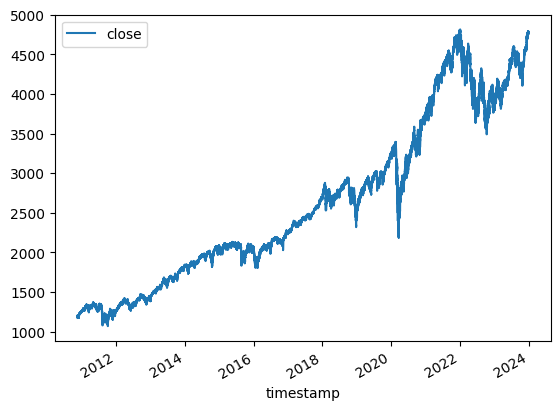

In [130]:
dfs_sandp_merged.plot(x="timestamp",y="close")

#BITCOIN

In [13]:
! git clone https://github.com/ff137/bitstamp-btcusd-minute-data


Cloning into 'bitstamp-btcusd-minute-data'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 324 (delta 6), reused 6 (delta 4), pack-reused 313 (from 1)
Receiving objects: 100% (324/324), 100.61 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [82]:
# Load historical and recent data
DATA_DIR = 'bitstamp-btcusd-minute-data/data'
df_hist = pd.read_csv(
    f'{DATA_DIR}/historical/btcusd_bitstamp_1min_2012-2025.csv.gz',
    compression='gzip'
)
df_recent = pd.read_csv(
    f'{DATA_DIR}/updates/btcusd_bitstamp_1min_latest.csv'
)

# Combine the datasets
df_bitcoin = pd.concat([df_hist, df_recent], ignore_index=True)
df_bitcoin.info()
df_bitcoin['timestamp']=pd.to_datetime(df_bitcoin['timestamp'], unit='s')
df_bitcoin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7418350 entries, 0 to 7418349
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 339.6 MB


In [84]:
deep_quality_report(df_bitcoin, name=f"Bitcoin")


========== Report for Bitcoin ==========
Total rows: 7418350
Time span: 2012-01-01 10:01:00 - 2026-02-08 01:10:00

[NaNs]
- No NaN issues found.

[Zeros]
- Columns with zero issues:
    • volume: 1310700 rows (17.6683% of all rows)
      Example rows:


,timestamp,open,high,low,close,volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0



[Negative values]
- No negative issues found.

[Duplicate timestamps]
- No duplicate timestamps found.

[Timestamp Gaps]
- No timestamp gaps detected.



<Axes: xlabel='timestamp'>

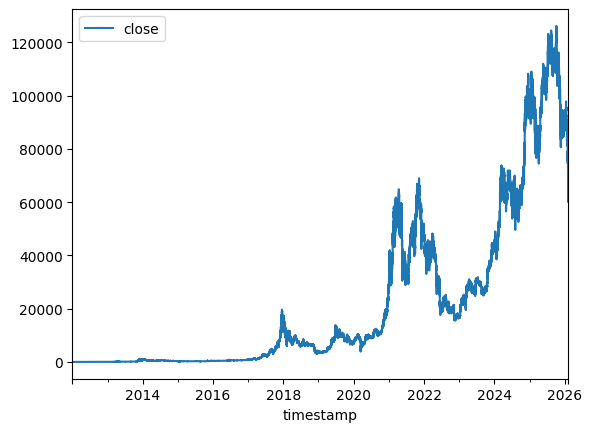

In [86]:
df_bitcoin.plot(x="timestamp",y="close")

# ETH

In [16]:
! pip install kagglehub[pandas-datasets]

In [88]:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "ETHUSD_1m_Bitstamp.csv"

# Load the latest version
df_ETH = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "imranbukhari/comprehensive-ethusd-1m-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df_ETH.head())

Using Colab cache for faster access to the 'comprehensive-ethusd-1m-data' dataset.
First 5 records:              Open time   Open  Close   High    Low  Volume
0  2017-08-16 16:45:00  300.0  300.0  300.0  300.0    0.02
1  2017-08-16 16:46:00  300.0  300.0  300.0  300.0    0.00
2  2017-08-16 16:47:00  300.0  300.0  300.0  300.0    0.00
3  2017-08-16 16:48:00  300.0  300.0  300.0  300.0    0.00
4  2017-08-16 16:49:00  300.0  300.0  300.0  300.0    0.00


In [108]:
df_ETH=df_ETH.rename(columns={"Open time": "timestamp"})
df_ETH['timestamp'] = pd.to_datetime(df_ETH['timestamp'].astype("string"))
deep_quality_report(df_ETH, name=f"ETH")


========== Report for ETH ==========
Total rows: 4287978
Time span: 2017-08-16 16:45:00 - 2025-10-11 11:04:00

[NaNs]
- No NaN issues found.

[Zeros]
- Columns with zero issues:
    • Volume: 796353 rows (18.5718% of all rows)
      Example rows:


,timestamp,Open,Close,High,Low,Volume
1,2017-08-16 16:46:00,300.0,300.0,300.0,300.0,0.0
2,2017-08-16 16:47:00,300.0,300.0,300.0,300.0,0.0
3,2017-08-16 16:48:00,300.0,300.0,300.0,300.0,0.0
4,2017-08-16 16:49:00,300.0,300.0,300.0,300.0,0.0
5,2017-08-16 16:50:00,300.0,300.0,300.0,300.0,0.0



[Negative values]
- No negative issues found.

[Duplicate timestamps]
- No duplicate timestamps found.

[Timestamp Gaps]
- Number of gaps: 2
- Average gap length: 0 days 00:02:00
- Longest gap: 0 days 00:02:00

  Example gap (first occurrence):
  Gap from 2025-04-10 14:41:00 → 2025-04-10 14:43:00


,timestamp,Open,Close,High,Low,Volume
4023236,2025-04-10 14:41:00,1581.8,1581.9,1581.9,1581.2,9.754389
4023237,2025-04-10 14:43:00,1581.2,1581.2,1581.2,1581.2,0.000000



  Longest gap:
  Gap from 2025-04-10 14:41:00 → 2025-04-10 14:43:00


,timestamp,Open,Close,High,Low,Volume
4023236,2025-04-10 14:41:00,1581.8,1581.9,1581.9,1581.2,9.754389
4023237,2025-04-10 14:43:00,1581.2,1581.2,1581.2,1581.2,0.000000



  Dates with gaps:
['2025-04-10', '2025-08-19']



<Axes: xlabel='timestamp'>

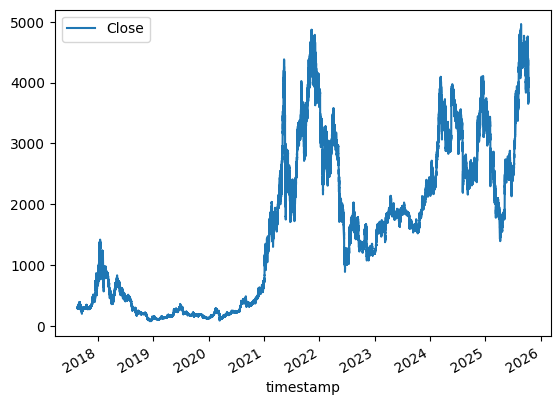

In [132]:
df_ETH.plot(x="timestamp",y="Close")